<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/transformers_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transformers 101.

In this notebook we will create a transformer model using multi-headed attention for neural machine translation task.

A little bit about transformers, before we get started.
RNNs were traditionally used for modelling seq2seq tasks, however they fail when the length of the sequence of input increases. The attention mechanism was introduced with idea to identify the relative weights of each words with respect to the other words so that the model can learn selectively.

Attention technique used with RNNs help learn hidden state for each word so that it is easy to pay more attention or discard words rather than learning the hidden state for the entire sentence. However this does not solve 3 problems

1.   The entire process is still sequential, it cannot be parallelized
2.   For a large sentence the time taken for translating the sentence to encodings is large.

Transformers introduced a completely new concept, with some learnings from how CNNs learn embeddings in parallel. Transformers use encoder, decoder architecture to learn attention weights in parallel and they can be used for a variety of tasks like neural language translation, question answering, next word prediction etc.

Complete understanding of how transformers work is not explained in this notebook but you may refer to the following blogs for better understanding.
- https://jalammar.github.io/illustrated-transformer/
- https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.XIWlzBNKjOR

This notebook builds a transformer model following the explanation from the original paper (https://arxiv.org/pdf/1706.03762.pdf). The implementation is taken from articles published at https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/.



In [ ]:
## Importing required libraries

import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout, Input
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import pathlib
import pickle
import random
import re
import unicodedata
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle


## Transformers Architecture.

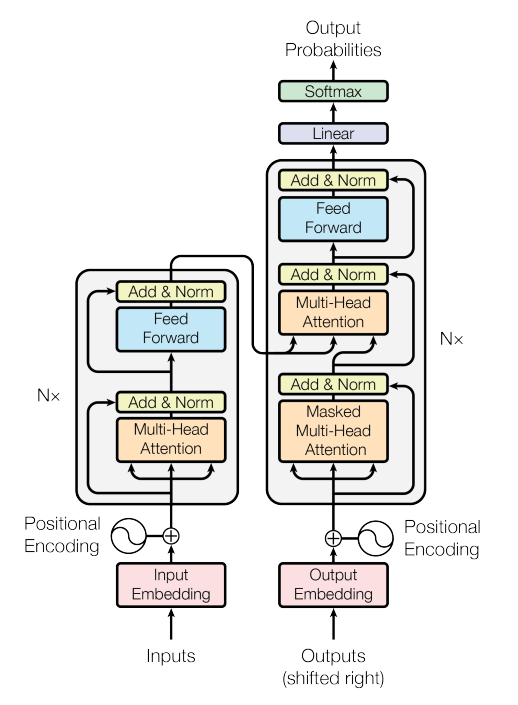

Image Source :  https://arxiv.org/pdf/1706.03762.pdf

We will use the bottom-up approach, i.e. build the transformer from the bottom most layer and then walk upwards. This notebook builds each layer as a separate model so that they can be plugged into a full fledged model.

## Download and Preprocess

In [ ]:
# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)

text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

('i no longer have a headache .', "[start] je n'ai plus mal à la tête . [end]")
('i really need a job .', "[start] j'ai vraiment besoin d'un travail . [end]")
('leave me alone .', '[start] laissez-moi tranquille  !  [end]')
("i'm glad that makes you happy .", '[start] je suis contente que ça vous rende heureux . [end]')
('do you understand that ?', '[start] le comprends-tu  ?  [end]')


In [ ]:
# find out how many distinct tokens exist
with open("text_pairs.pickle", "rb") as fp:
    text_paris = pickle.load(fp)

eng_tokens, fra_tokens = set(), set()
eng_maxlength, fra_maxlength = 0, 0
for eng, fra in text_paris:
    eng_token, fra_token = eng.split(), fra.split()
    eng_maxlength = max(len(eng_token), eng_maxlength)
    fra_maxlength = max(len(fra_token), fra_maxlength)
    eng_tokens.update(eng_token)
    fra_tokens.update(fra_token)
print(f"Total English tokens = {len(eng_tokens)}")
print(f"Total French tokens = {len(fra_tokens)}")
print(f"Maximum English sequence length = {eng_maxlength}")
print(f"Maximum French sequence length = {fra_maxlength}")

Total English tokens = 14969
Total French tokens = 29219
Maximum English sequence length = 51
Maximum French sequence length = 60


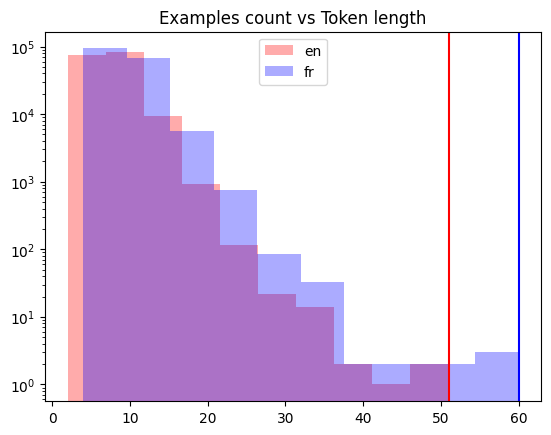

In [ ]:
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

## Prepare dataset

In [ ]:
class PrepareDataset:

  def __init__(self, n_sentences=1000, max_seq_length=20, **kwargs):

    super(PrepareDataset, self).__init__(**kwargs)
    self.n_sentences = n_sentences
    self.val_split = 0.15
    self.max_seq_length = max_seq_length

  def find_vocab_size(self, tokenizer, dataset):
    tokenizer.fit_on_texts(dataset)
    return len(tokenizer.word_index) + 1

  def format_dataset(self, eng, fra):
    eng = self.eng_vectorizer(eng)
    # eng = eng[:, :eng.max_tokens]
    fra = self.fra_vectorizer(fra)
    # fra = fra[:, :fra.max_tokens+1]
    source = (eng, fra[:, :-1])
    target = fra[:, 1:]
    return source, target

  def __call__(self, filename, batch_size=64, **kwargs):

    text_pairs = pickle.load(open(filename, 'rb'))
    total_len_text_pairs = len(text_pairs)

    if self.n_sentences is None:
      dataset = text_pairs[:]
    else:
      dataset = text_pairs[:self.n_sentences]

    shuffle(dataset)
    len_text_pairs = len(dataset)

    n_val_index = int(self.val_split * len_text_pairs)
    n_train_index = len_text_pairs - 2 * n_val_index
    train_pairs = dataset[:n_train_index]
    test_pairs = dataset[n_train_index:n_train_index + n_val_index]
    val_pairs = dataset[n_train_index + n_val_index:]

    eng_vectorizer = TextVectorization(
        max_tokens = 10000,  # learning from data analysis
        standardize = None,
        split = "whitespace",
        output_mode = "int",
        output_sequence_length = self.max_seq_length
    )

    fra_vectorizer = TextVectorization(
        max_tokens = 20000,  # learning from data analysis
        standardize = None,
        split = "whitespace",
        output_mode = "int",
        output_sequence_length = self.max_seq_length + 1
    )

    train_eng_texts = [pairs[0] for pairs in train_pairs]
    train_fra_texts = [pairs[1] for pairs in train_pairs]

    eng_vectorizer.adapt(train_eng_texts)
    fra_vectorizer.adapt(train_fra_texts)

    self.eng_vectorizer = eng_vectorizer
    self.fra_vectorizer = fra_vectorizer
    self.train = train_pairs
    self.test = test_pairs

    eng_texts_train, fra_texts_train = zip(*train_pairs)
    eng_texts_val, fra_texts_val = zip(*val_pairs)

    train_ds = tf.data.Dataset.from_tensor_slices((list(eng_texts_train), list(fra_texts_train))).shuffle(2048).batch(batch_size).map(self.format_dataset).prefetch(16).cache()
    val_ds = tf.data.Dataset.from_tensor_slices((list(eng_texts_val), list(fra_texts_val))).shuffle(2048).batch(batch_size).map(self.format_dataset).prefetch(16).cache()
    # the vectorizers are used during the inference
    return train_ds, val_ds, eng_vectorizer, fra_vectorizer, train_pairs, test_pairs, val_pairs

In [ ]:
n_sentences = 1000
dataset = PrepareDataset(n_sentences=n_sentences)
train_ds, val_ds, eng_vec, fra_vec, train_pairs, test_pairs, val_pairs = dataset("text_pairs.pickle")
for (eng, fr), fr_labels in train_ds.take(1):
  break
print(eng.shape)
print(fr.shape)
print(fr_labels.shape)

print(fr[0][:10])
print(fr_labels[0][:10])

(64, 20)
(64, 20)
(64, 20)
tf.Tensor([ 2  6  7 18  1  4  3  0  0  0], shape=(10,), dtype=int64)
tf.Tensor([ 6  7 18  1  4  3  0  0  0  0], shape=(10,), dtype=int64)


In [ ]:
eng_lookup = list(eng_vec.get_vocabulary())
fra_lookup = list(fra_vec.get_vocabulary())
eng_sen, fra_sen, fra_source = "", "",""
print(eng[1])
for index in eng[1]:
  eng_sen += eng_lookup[index] + " "
for index in fr[1]:
  fra_source += fra_lookup[index] + " "
for index in fr_labels[1]:
  fra_sen += fra_lookup[index] + " "
print(f"source: {eng_sen}")
print(f"fra source: {fra_source}")
print(f"target: {fra_sen}")

tf.Tensor([1 9 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int64)
source: [UNK] tom .                  
fra source: [start] trouvez tom . [end]                
target: trouvez tom . [end]                 


## Vocab size

In [ ]:
eng_vocab_size = len(list(eng_vec.get_vocabulary()))
fra_vocab_size = len(list(fra_vec.get_vocabulary()))
print(f"English vocab size: {eng_vocab_size}")
print(f"French vocab size: {eng_vocab_size}")

English vocab size: 128
French vocab size: 128


## Positional Embedding Layer



In [ ]:
# Positional embedding matrix - This matrix represents the position of the word in the sentence.
# It takes input as length of the sentence and size of the vector embeddings
# The output is a matrix where every row is a word in the sentence, each row represents the position encoding of that word
# The length of each row is equal to the length of word embeddings.
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

pos_matrix = positional_encoding(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.84147096  0.00999983  0.5403023   0.99995   ]
 [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
 [ 0.14112     0.0299955  -0.9899925   0.99955004]], shape=(4, 4), dtype=float32)


In [ ]:
# Positional Embedding
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
eng_pos = PositionalEmbedding(eng_vocab_size, 512)
fra_pos = PositionalEmbedding(fra_vocab_size, 512)
print(eng_pos(eng).shape)
print(fra_pos(fr).shape)

(64, 20, 512)
(64, 20, 512)



## Self Attention Layer

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
enc_output = eng_pos(eng)
print(enc_output.shape)
print(sample_gsa(enc_output).shape)

(64, 20, 512)
(64, 20, 512)


## Cross Attention Layer

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
emb_output_fra = fra_pos(fr)
print(emb_output_eng.shape)
print(emb_output_fra.shape)
print(sample_ca(emb_output_eng, emb_output_fra).shape)

(64, 20, 512)
(64, 20, 512)
(64, 20, 512)


## Causal Self Attention

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
print(emb_output_eng.shape)
print(sample_csa(emb_output_eng).shape)

(64, 20, 512)
(64, 20, 512)


## Feedforward Layer

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [ ]:
sample_ffn = FeedForward(512, 2048)
print(sample_ffn(emb_output_eng).shape)

(64, 20, 512)


## Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(emb_output_eng.shape)
print(sample_encoder_layer(emb_output_eng).shape)

(64, 20, 512)
(64, 20, 512)


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)
sample_encoder_output = sample_encoder(eng, training=False)
print(eng.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 20)
(64, 20, 512)


## Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=emb_output_fra, context=emb_output_eng)

print(emb_output_eng.shape)
print(emb_output_fra.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 20, 512)
(64, 20, 512)
(64, 20, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)
output = sample_decoder(x=fr,context=emb_output_eng)
# Print the shapes.
print(fr.shape)
print(emb_output_fra.shape)
print(output.shape)

(64, 20)
(64, 20, 512)
(64, 20, 512)


In [ ]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 20, 20])

## Transformer Model

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Training Utilities

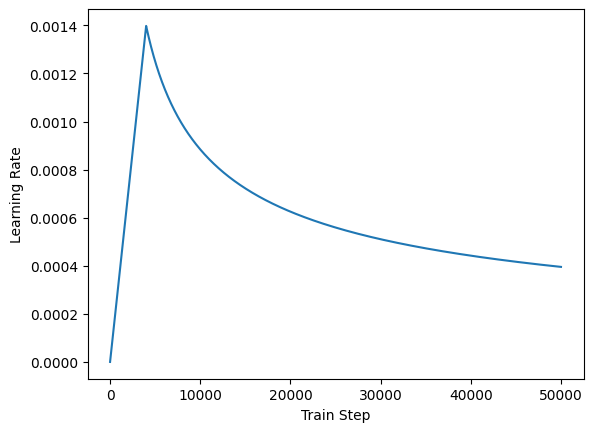

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps
    }
    return config

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = pred==label
  mask = label !=0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


## Final Model

In [ ]:
# Parameters
n_sentences = None
dataset = PrepareDataset(n_sentences=n_sentences, max_seq_length=20)
train_ds, val_ds, eng_vec, fra_vec, train_pairs, test_pairs, val_pairs = dataset("text_pairs.pickle")
num_layers = 4
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.1
vocab_size_en = len(eng_vec.get_vocabulary())
vocab_size_fr = len(fra_vec.get_vocabulary())
print(f"English vocab size: {vocab_size_en}")
print(f"French vocab size: {vocab_size_fr}")

English vocab size: 10000
French vocab size: 20000


In [ ]:
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_en,
    target_vocab_size=vocab_size_fr,
    dropout_rate=dropout_rate)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])


## Training

In [ ]:
# Testing the output shapes
for (eng, fr), fr_labels in train_ds.take(1):
  break
output = model((eng, fr))
print(output.shape)

(64, 20, 20000)


In [ ]:
epochs = 10
# history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

Epoch 1/10
1828/1828 [==============================] - 315s 153ms/step - loss: 3.8180 - masked_accuracy: 0.4561 - val_loss: 2.6215 - val_masked_accuracy: 0.5481
Epoch 2/10
 478/1828 [======>.......................] - ETA: 2:51 - loss: 3.1754 - masked_accuracy: 0.4736

## Inference

In [ ]:
# training parameters used
seq_len = 20
def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vec([sentence])
    lookup = list(fra_vec.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vec([" ".join(output_sentence)])
        dec_tokens = vector[:, :-1]
        pred = model([enc_tokens, dec_tokens])
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 5
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
be calm .
== [start] soyez calmes  !  [end]
-> [start] soyez [UNK] ! [end]

Test 1:
i'm armed .
== [start] je suis armé . [end]
-> [start] je suis [UNK] . [end]

Test 2:
wait here .
== [start] attends là . [end]
-> [start] nous avons . [end]

Test 3:
i am busy .
== [start] je suis occupé . [end]
-> [start] je suis [UNK] . [end]

Test 4:
get lost !
== [start] va au diable  !  [end]
-> [start] [UNK] ! [end]

